# epymorph: migrating from v0.4 to v0.5

An interactive workshop of side-by-side comparisons: this is the v0.4 version.

Running simulation (StandardSimulation):
• 2015-01-01 to 2016-08-23 (600 days)
• 1 geo nodes
|####################| 100% 
Runtime: 0.123s


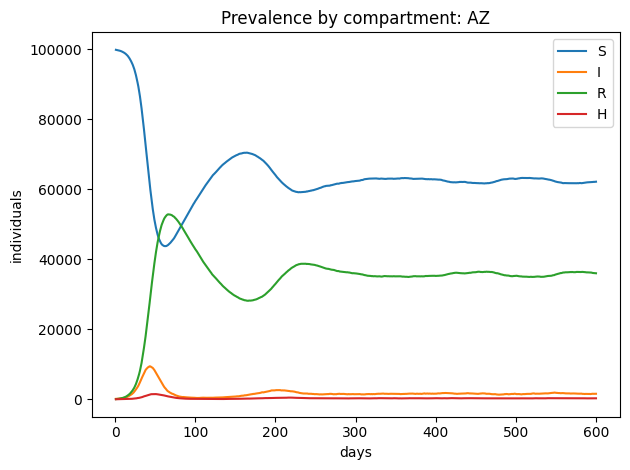

In [1]:
# Example 1: basic simulation
# watch for changes -- RUME, Simulators, Initializers, geo usage

from functools import partial

from epymorph import *
from epymorph.initializer import single_location

sim = StandardSimulation(
    geo=geo_library['single_pop'](),
    ipm=ipm_library['sirh'](),
    mm=mm_library['no'](),
    initializer=partial(single_location, location=0, seed_size=100),
    time_frame=TimeFrame.of("2015-01-01", 600),
    params={
        'beta': 0.4,
        'gamma': 1 / 4,
        'xi': 1 / 90,
        'hospitalization_prob': 0.1,
        'hospitalization_duration': 7,
    },
    rng=default_rng(42),
)

with sim_messaging(sim):
    output = sim.run()

plot_pop(output, pop_idx=0)

Running simulation (StandardSimulation):
• 2015-01-01 to 2015-05-31 (150 days)
• 6 geo nodes
|####################| 100% 
Runtime: 0.258s


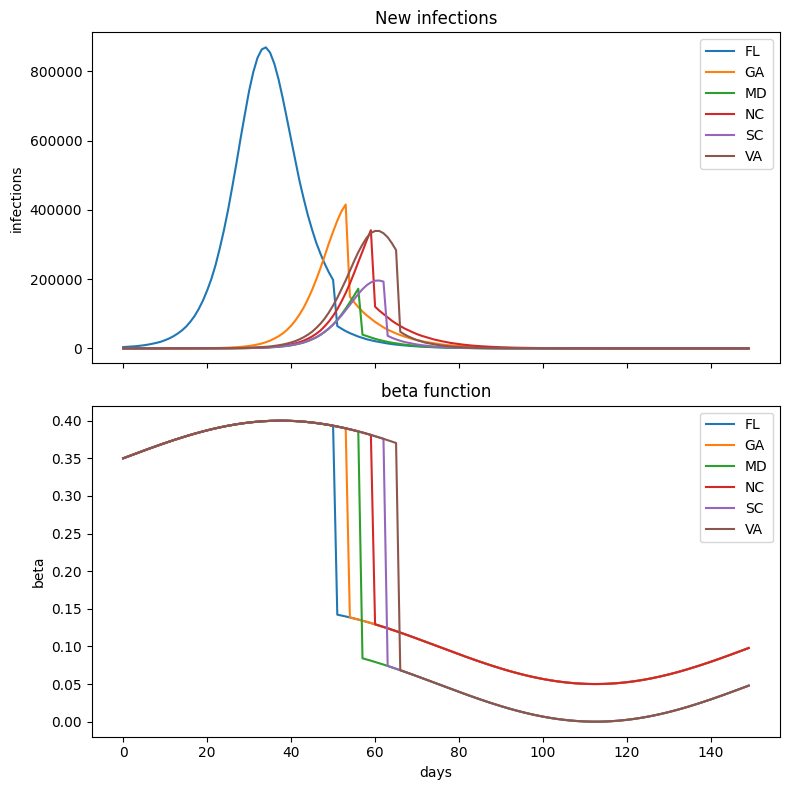

In [2]:
# Example 2: custom parameter functions
# watch for changes -- defining and evaluating params functions which access data attributes

from functools import partial
from math import pi, sin

import matplotlib.pyplot as plt
import numpy as np

from epymorph import *
from epymorph.initializer import single_location


def beta_fn(t, n):
    x = 0.35 + 0.05 * sin(2 * pi * (t / dim.days))
    cutoff = 50 + (n * 3)
    if t > cutoff:
        # `geo` is a proxy with which we can access data attributes on the geo
        pop = geo['population'][n]
        cut = 0.3 if pop < 9_000_000 else 0.25
        x -= cut
    return x


sim = StandardSimulation(
    ipm=ipm_library['sirs'](),
    mm=mm_library['pei'](),
    geo=geo_library['pei'](),
    initializer=partial(single_location, location=0, seed_size=10_000),
    time_frame=TimeFrame.of("2015-01-01", 150),
    params={
        'beta': beta_fn,
        'gamma': 1 / 6,
        'xi': 1 / 90,
        'theta': 0.1,
        'move_control': 0.9,
    },
)

with sim_messaging(sim):
    out = sim.run()

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8, 8))
x_axis = np.arange(out.dim.days)
ax1.set(title='New infections', ylabel='infections')
ax1.plot(x_axis, out.incidence_per_day[:, :, 0], label=out.geo_labels)
ax1.legend()

# For the sake of graphing beta, I can fetch it in its fully-evaluated form
# from the sim object.
ax2.set(title='beta function', ylabel='beta', xlabel='days')
ax2.plot(x_axis, sim.params['beta'], label=out.geo_labels)
ax2.legend()

fig.tight_layout()
plt.show()

Running simulation (StandardSimulation):
• 2015-01-01 to 2015-02-20 (50 days)
• 6 geo nodes
|####################| 100% 
Runtime: 0.032s


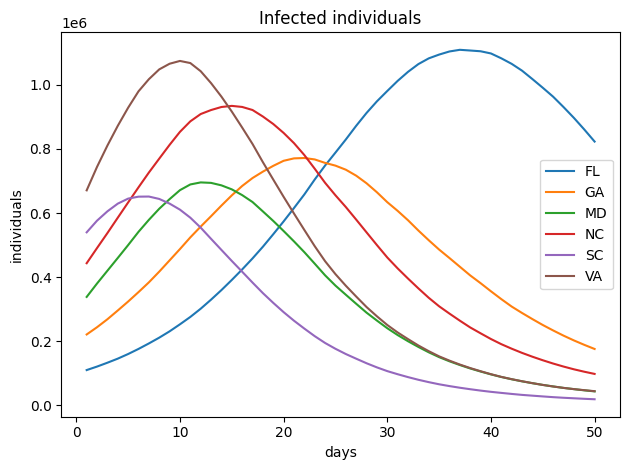

In [4]:
# Example 3: custom initialization
# watch for changes -- defining initializers, class parameterization

import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray

from epymorph import *
from epymorph.engine.context import RumeContext


def my_initializer(ctx: RumeContext, population: NDArray[np.integer], infected_multiplier: int = 100000) -> NDArray[SimDType]:
    # This calculation is arbitrary, just for demonstration.
    _, N, C, _ = ctx.dim.TNCE
    initial = np.zeros(shape=(N, C), dtype=SimDType)
    initial[:, 0] = population
    for n in range(N):
        initial[n, 0] -= infected_multiplier * (n + 1)
        initial[n, 1] += infected_multiplier * (n + 1)
    return initial


sim = StandardSimulation(
    geo=geo_library['pei'](),
    ipm=ipm_library['pei'](),
    mm=mm_library['no'](),
    initializer=my_initializer,
    time_frame=TimeFrame.of("2015-01-01", duration_days=50),
    params={
        'infection_duration': 4,
        'immunity_duration': 90,
        'infected_multiplier': 100000,
    },
)

with sim_messaging(sim):
    out = sim.run()

fig, ax = plt.subplots()
ax.set_title(f"Infected individuals")
ax.set_xlabel('days')
ax.set_ylabel('individuals')
ax.plot(out.ticks_in_days, out.prevalence[:, :, 1], label=out.geo_labels)
ax.legend()
fig.tight_layout()
plt.show()

In [ ]:
# Example 4: multistrata simulations
# there's no way to do this (fully) in v0.4!